Load data


In [2]:
#Reload kernel , see comment Slack about clearing the memory after updating Notebook
%load_ext autoreload
%autoreload 2

This notebook will create a number of dataframe
df=original dataframe based on HECTORdata_aggregated.parquet
df1=df without date
limited_col_df1= df1 with less coloms , coloms removed after pairplot

In [3]:
pip install duckdb


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:

import numpy as np 
import pandas as pd
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
filename = '/home/joelva/code/pgt-group-3/data/raw/Complete_Set/HECTORdataAggregated-2.parquet'
df = pd.read_parquet(filename)
df.describe


<bound method NDFrame.describe of                  Vdatetime                         datetime  BatMaxV  BatMinV  \
0       2022-08-01 04:04:1 2022-08-01 04:04:19.980000+00:00      0.0      0.0   
1       2022-08-01 04:04:2 2022-08-01 04:04:29.770000+00:00      0.0      0.0   
2       2022-08-01 04:04:3 2022-08-01 04:04:39.730000+00:00      0.0      0.0   
3       2022-08-01 04:04:4 2022-08-01 04:04:49.990000+00:00      0.0      0.0   
4       2022-08-01 04:04:5 2022-08-01 04:04:59.770000+00:00      0.0      0.0   
...                    ...                              ...      ...      ...   
871716  2023-04-29 16:03:5 2023-04-29 16:03:59.970000+00:00      0.0      0.0   
871717  2023-04-29 16:04:0 2023-04-29 16:04:09.930000+00:00      0.0      0.0   
871718  2023-04-29 16:04:1 2023-04-29 16:04:19.940000+00:00      0.0      0.0   
871719  2023-04-29 16:04:2 2023-04-29 16:04:29.960000+00:00      0.0      0.0   
871720  2023-04-29 16:04:3 2023-04-29 16:04:35.180000+00:00      0.0      0

In [6]:
import duckdb

In [7]:
#code for slecting a sinlge day
#duckdb.query("SELECT  * FROM df WHERE _timestamp like '%2022-08-01%'").df()

In [8]:
#Make a df based on a specific date or time

#df2 = duckdb.query("SELECT  * FROM df WHERE _timestamp like '%2022-08-01%'").df()

In [9]:
column_names = df.columns
print("Column names:")
print(column_names)

Column names:
Index(['Vdatetime', 'datetime', 'BatMaxV', 'BatMinV', 'BatSOC',
       'BatTotalCurrent', 'BatTotalVoltage', 'CompOnOff', 'StopOnOff',
       'ThrottlePerc', 'BrakePerc', 'Signal', 'TotalDistance', 'FrontAxle',
       'RearAxle1', 'RearAxle2', 'CompPower', 'FC2AirFlow', 'FC2Cool',
       'FC2Current', 'FC2Volt', 'FC3AirFlow', 'FC3Cool', 'FC3Current',
       'FC3Volt', 'FC1AirFlow', 'FC1Cool', 'FC1Current', 'FC1Volt',
       'GPSAltitude', 'GPSLatitude', 'GPSLongitude', 'H2Perc', 'H2Press',
       'H2Temp', 'H2Weight', 'HVACDraw', 'MotorRPM', 'MotorTorque',
       'MotorUseCurrent', 'MotorTemp', 'BattOutputPower', 'MotorPowerDraw',
       'TotalFCPower', 'ActualSpeed', 'TotalPowerDraw'],
      dtype='object')


In [10]:
df.shape

(871721, 46)

PART1 MotorPowerDraw-find correlation between features
Check for pearson correlation (-1 to +1 where +1 is perfect correlation) 

1. Calulatie covariation
$$cov(x,y) = \frac{1}{n} \sum_i (x_i - \bar{x})(y_i - \bar{y})$$

2. normalize via dividing by std dev of the variables

$$ r = \frac{cov(x,y)}{\sigma_x \sigma_y}$$

where $\sigma$ is the standard deviation.  The resulting value is the Pearson coefficient. We will use the heatmap for checking this between the variables

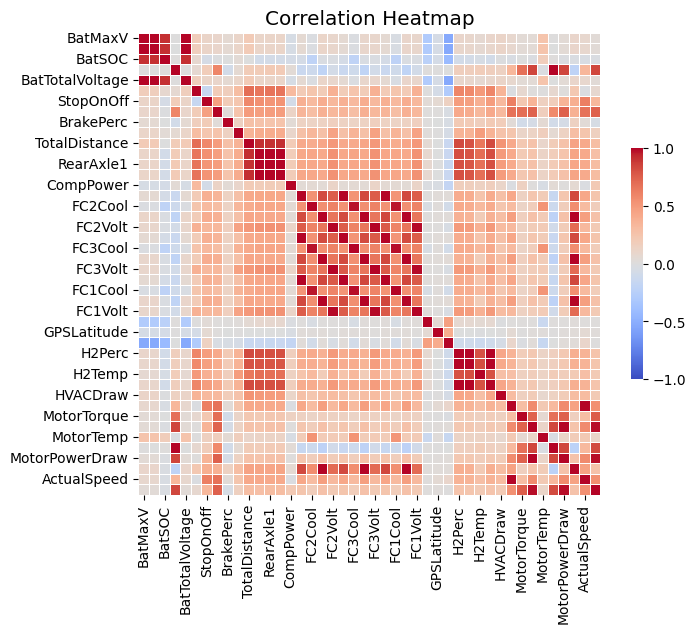

In [11]:
floats = df.select_dtypes(include="float64")
df1 = floats.corr()

# Set up the heatmap figure size
plt.figure(figsize=(8, 6))

# Customize the heatmap using seaborn's heatmap function without annotations
heatmap = sns.heatmap(
    df1,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Set font scale for better readability
sns.set(font_scale=1.2)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

Correlation high   namely for features BatSOC, BatTotalVoltage , BatMaxV_2, RearAxle1, H2Perc, H2Temp

## Finding correlation through regularization for MotorPowerDraw

 lets start with plotting the correlations. Because we have a 40+  features, this is too much for a heatmap, so we will limit ourselves to the correlation between the features and the MotoPowerDraw

the variable 'MotorPowerDraw' has correlation 1.0 with itself, but we have a number of vriables above 0.4-select these variables

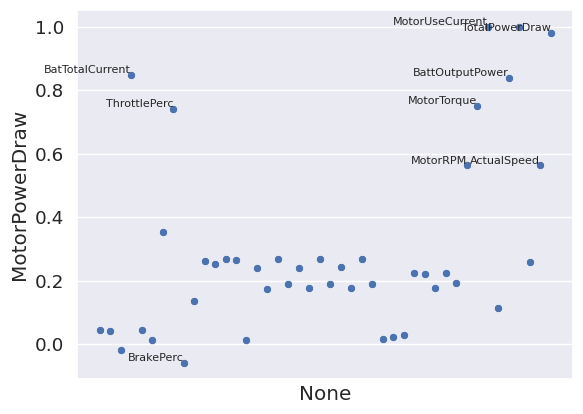

Features with correlation > 0.4 with 'MotorPowerDraw':
MotorTorque
ActualSpeed
MotorUseCurrent
BrakePerc
MotorRPM
ThrottlePerc
BatTotalCurrent
BattOutputPower
TotalPowerDraw


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df1' is your DataFrame

# Create a scatter plot
sns.scatterplot(x=df1.index, y=df1['MotorPowerDraw'])

# Initialize a list to store features with correlation > 0.4
correlated_features = []

# Annotate each point with its corresponding feature
for i, row in df1.iterrows():
    for col in df1.columns:
        if col != 'MotorPowerDraw':
            corr = df1['MotorPowerDraw'].corr(df1[col])
            if abs(corr) > 0.4 and i == df1[col].idxmax():
                correlated_features.append(col)
                plt.annotate(col, (i, df1['MotorPowerDraw'].loc[i]), ha='right', va='bottom', fontsize=8)

plt.xticks([])  # Hide x-axis ticks (if needed)
plt.show()

# List features with correlation > 0.4 with 'MotorPowerDraw'
print("Features with correlation > 0.4 with 'MotorPowerDraw':")
for feature in set(correlated_features):
    print(feature)


Features selected vi scatterplot:'BrakePerc', 'MotorTorque' ,'BatTotalCurrent' ,, 'MotorUseCurrent', 'TotalPowerDraw', 'BatTotalCurrent' , 'BattOutputPower' , 'MotorTorque' ,'ThrottlePerc' , 'MotorRPM' ,'ActualSpeed'. ALso "BrakePerc to be noted  since it seems to have a negative correlation

Regularization: As a comparision to above scatterplot, we can (mis) use linear regression to identify the features , which has the highest impact on the target 'MotorPowerDraw' . Regularization adds a penalty to the coefficients in a multiple linear regression model and chose the function with the smallest values for the coefficients 

In [13]:
#Create a new df for Regression and elasticnet to (mis)use linear regression to find the most important features for our target (MotorPowerDraw and CompPower)
#We need to drop NANs to run the regression
# orders the rows in df based on Ascending values for colom Vdatetime and then drops colom Vdatetime and datetime and create a new df

# Sort DataFrame based on ascending values in 'Vdatetime' column
df_sorted = df.sort_values(by='Vdatetime', ascending=True)

# Drop 'Vdatetime' and 'datetime' columns and create a new DataFrame
df_ordered_no_datetime = df_sorted.drop(columns=['Vdatetime', 'datetime'])

#drop rows with NANS
# Count number of rows before dropping NaNs
rows_before = df_ordered_no_datetime.shape[0]

# Drop rows containing NaN values
df_ordered_no_datetime_dropped_nan = df_ordered_no_datetime.dropna()

# Count number of rows after dropping NaNs
rows_after = df_ordered_no_datetime_dropped_nan.shape[0]

# Calculate number of rows dropped
rows_dropped = rows_before - rows_after

# Show the number of rows dropped
print(f"{rows_dropped} rows were dropped due to NaN values.")
print(f"{rows_before} rows before drop NaN values.")
# If you want to use the modified DataFrame without NaNs:
# df = df_dropped

690858 rows were dropped due to NaN values.
871721 rows before drop NaN values.


Top 10 most significant features:
TotalPowerDraw: 1196126804411181.5
CompPower: -689125629092399.8
TotalDistance: 669982670548801.4
MotorTorque: 645412589171371.4
TotalFCPower: 609208365917730.1
HVACDraw: -184837239627215.2
MotorRPM: 103217066618544.47
FC3AirFlow: 100506981464154.92
FC1Current: 70019045990311.24
FC2Current: 68884604029723.43


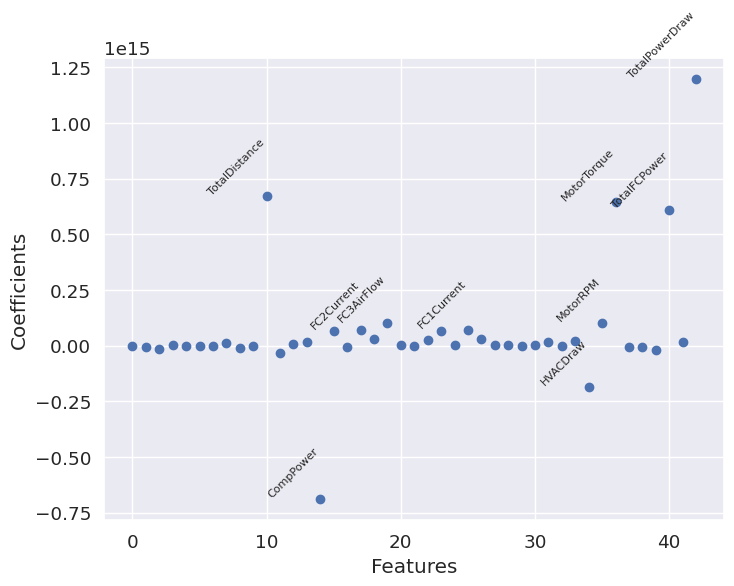

In [14]:
#Regression continues
from sklearn.linear_model import SGDRegressor

# Assuming X and y are defined as follows:
X = df_ordered_no_datetime_dropped_nan.drop(columns=["MotorPowerDraw"]).values
y = df_ordered_no_datetime_dropped_nan["MotorPowerDraw"].values

regressor = SGDRegressor(penalty="elasticnet", random_state=42)
regressor.fit(X, y)
coef = regressor.coef_

# Get column names and their corresponding coefficients
feature_names = df_ordered_no_datetime_dropped_nan.drop(columns=["MotorPowerDraw"]).columns.tolist()
feature_coef = {col: coef[idx] for idx, col in enumerate(feature_names)}

# Get indices of top 10 features based on absolute coefficient values
top_features = sorted(feature_coef.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

# Plot coefficients
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(coef.T, 'o')

# Set labels for x and y axes
plt.xlabel("Features")
plt.ylabel("Coefficients")

# Annotate points with feature names for top features
for feature, coef_val in top_features:
    idx = feature_names.index(feature)  # Get index of feature name
    plt.text(idx, coef_val, f'{feature}', ha='right', va='bottom', fontsize=8, rotation=45)

# Print names of the top 10 most significant features
print("Top 10 most significant features:")
for feature, coef_val in top_features:
    print(f"{feature}: {coef_val}")

# Display plot
plt.show()


Regression with Elasticnet give the following features :  'MotorTorque', 'TotalPowerDraw','MotorRPM', which are the saem as for the Scatterplot. Features not in the scatterplot are ' TotalDistance' , 'FC2Current',' FV3AirFlow',' FC1Current and negative features 'HVACDraw' and 'CompPower' 

#continue with the features with high correlations from Scatterplot/Regression with Elasticnet and the heatmap, Ignoring the additional features from Regression with Elasticnet  which was not found via Scatterplot
#Scatterplot Features with correlation > 0.4 with 'MotorPowerDraw': #BrakePerc,MotorTorque,BatTotalCurrent,ThrottlePerc,MotorRPM,MotorUseCurrent,TotalPowerDraw,ActualSpeed,BattOutputPower
#Elasticnet Top 10 most significant features:TotalPowerDraw: CompPower:TotalDistance,MotorTorque,TotalFCPower,HVACDraw,MotorRPM,FC3AirFlow,FC1Current,FC2Current
#Heatmap higly correlatied features:  BatSOC, BatTotalVoltage , BatMaxV_2, RearAxle1, H2Perc, H2Temp

In [15]:

selected_columns = ['MotorPowerDraw', 'MotorUseCurrent', 'TotalPowerDraw', 'BatTotalCurrent' , 'BattOutputPower' , 'MotorTorque' ,'ThrottlePerc' , 'MotorRPM' ,'ActualSpeed', 'BattOutputPower', 'BrakePerc' ]
limited_col_df = df[selected_columns].copy()

In [16]:
column_names = limited_col_df.columns
print("Column names:")
print(column_names)
limited_col_df.dtypes

Column names:
Index(['MotorPowerDraw', 'MotorUseCurrent', 'TotalPowerDraw',
       'BatTotalCurrent', 'BattOutputPower', 'MotorTorque', 'ThrottlePerc',
       'MotorRPM', 'ActualSpeed', 'BattOutputPower', 'BrakePerc'],
      dtype='object')


MotorPowerDraw     float64
MotorUseCurrent    float64
TotalPowerDraw     float64
BatTotalCurrent    float64
BattOutputPower    float64
MotorTorque        float64
ThrottlePerc       float64
MotorRPM           float64
ActualSpeed        float64
BattOutputPower    float64
BrakePerc          float64
dtype: object

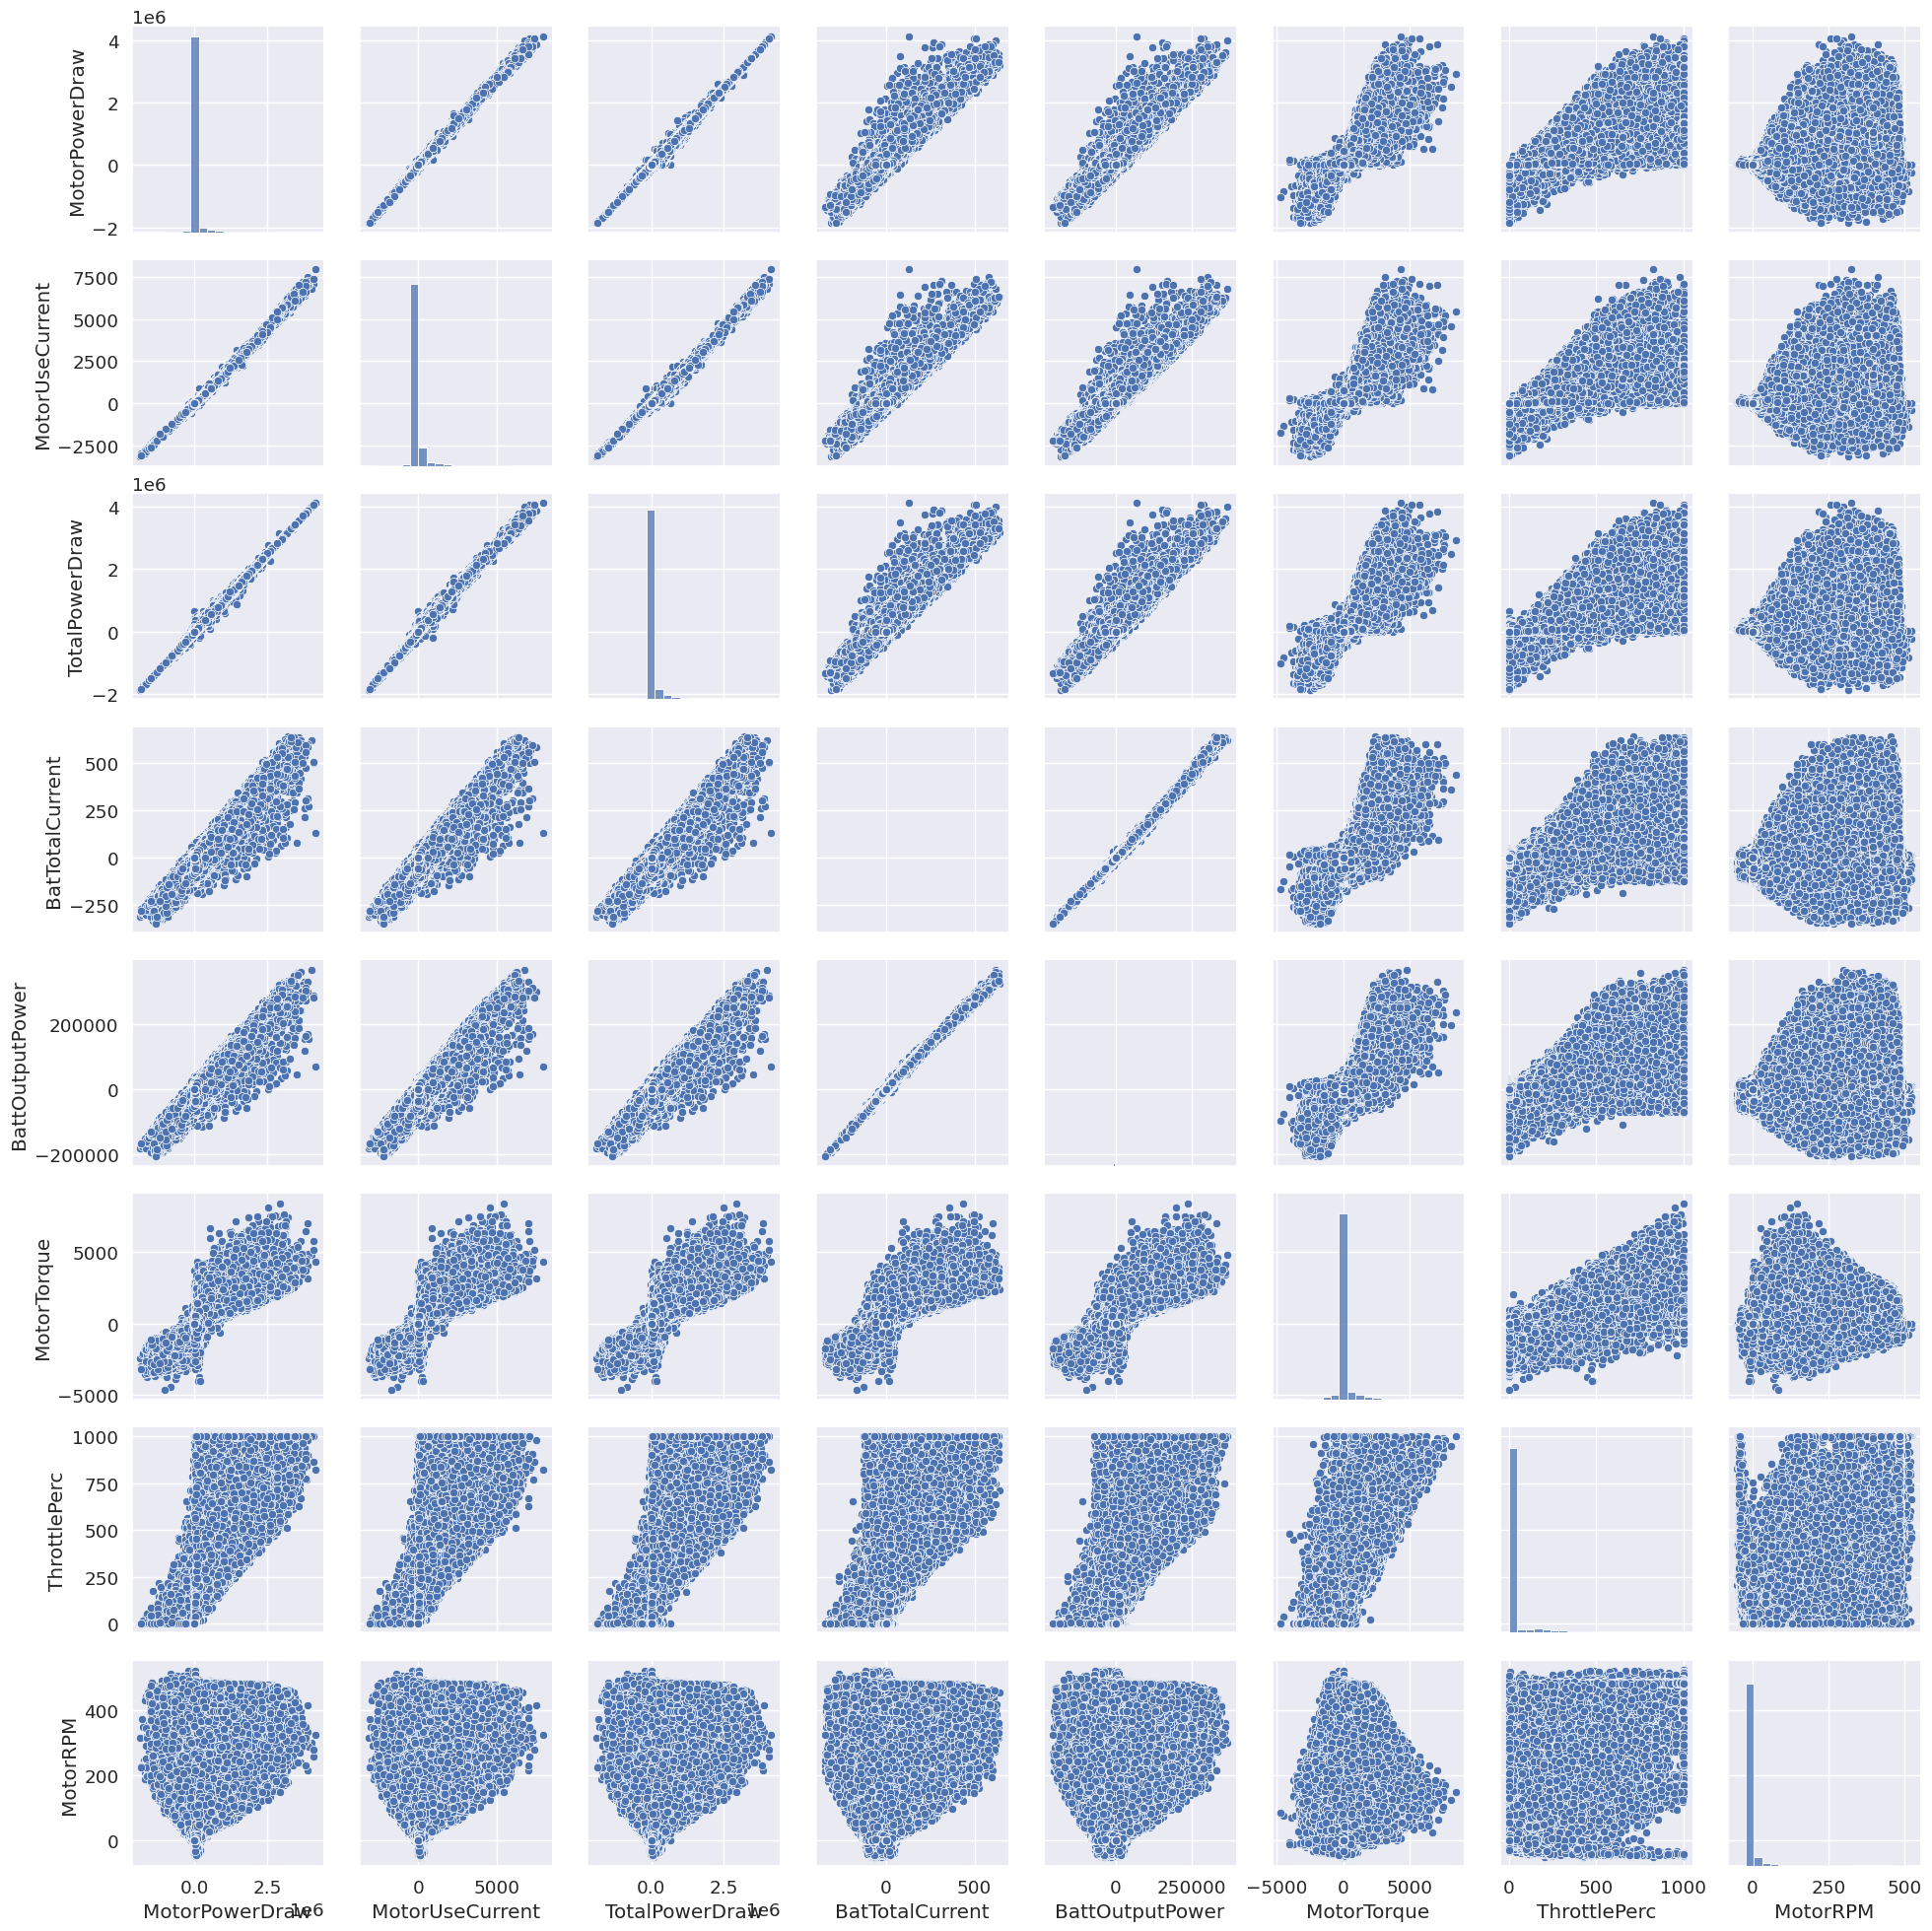

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'limited_col_df' is your DataFrame with selected columns

# Select a subset of columns (e.g., first 8 columns) , mor colos create kernelcrahs
subset_cols = limited_col_df.iloc[:, :8]  # Modify the slice according to your data

# Create pair plot with the subset of numeric columns
sns.pairplot(subset_cols)
plt.show()

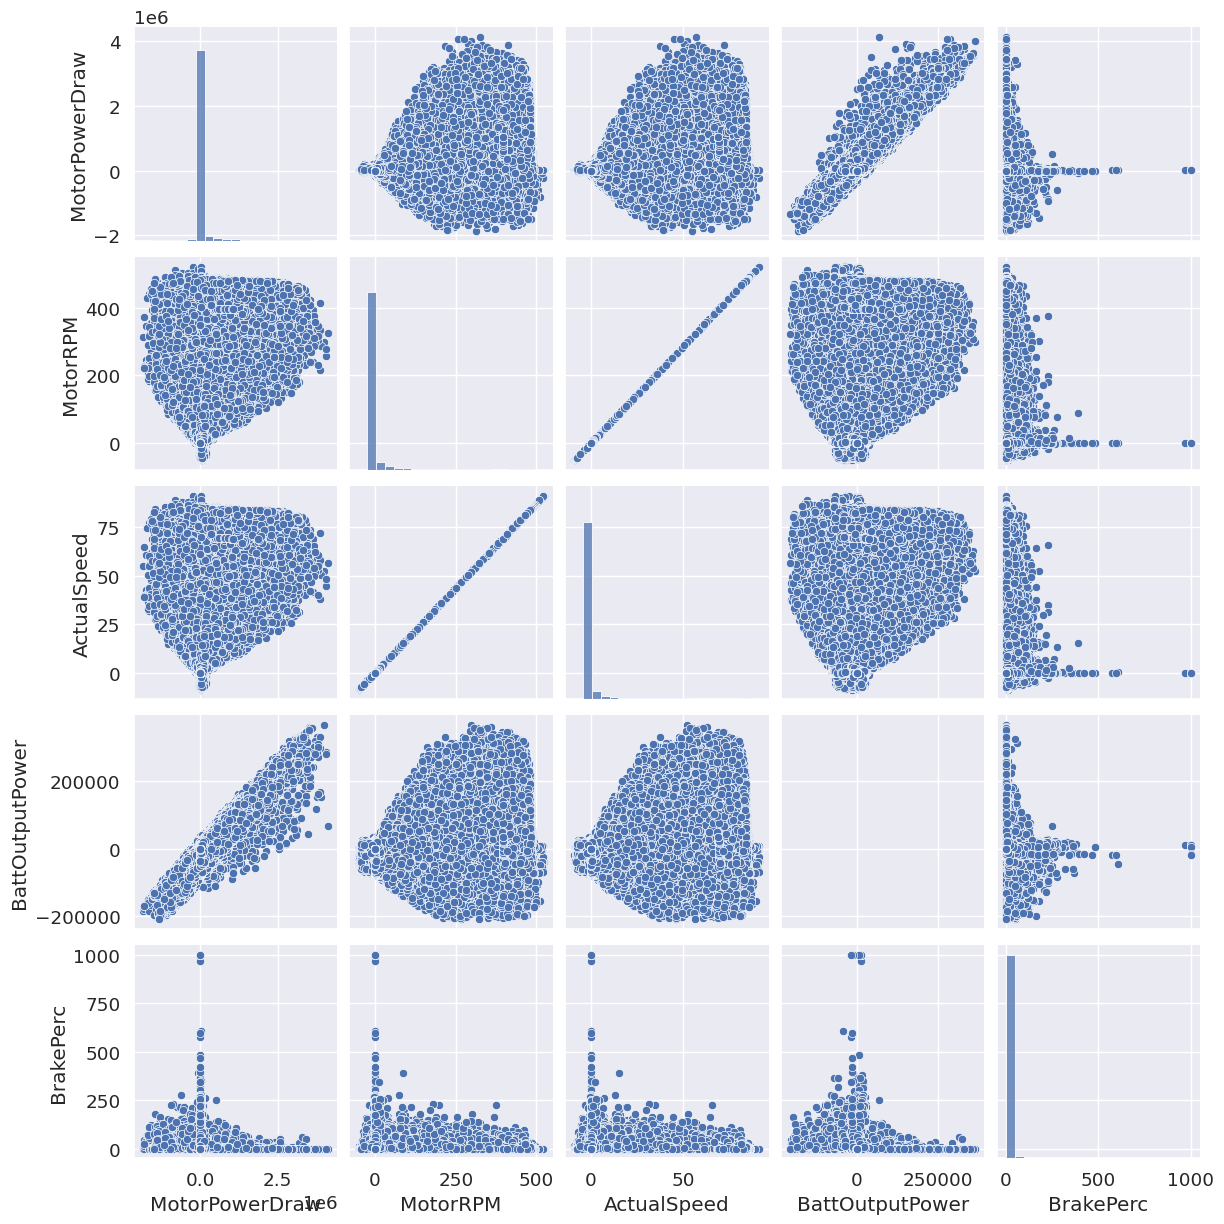

In [18]:
# Since kernel error occur in above field, the parilplot is split into two different cells 
#Select the specified columns for pair plot
subset_cols = limited_col_df.iloc[:, [0, 7, 8, 9, 10]]  # Selecting columns 1, 8, 9, 10, 11 (Python index starts from 0)

# Create pair plot with the selected columns
sns.pairplot(subset_cols)
plt.show()

We now have a df 'limited_col_df' with coloms MotorUseCurrent', 'TotalPowerDraw', 'BatTotalCurrent' , 'BattOutputPower' , 'MotorTorque' ,'ThrottlePerc' , 'MotorRPM' ,'ActualSpeed' which all have a correlation with MotorPowerDrwa above>0.4
Feature 'BrakePerc' is also inldued, since it is negatively correlated

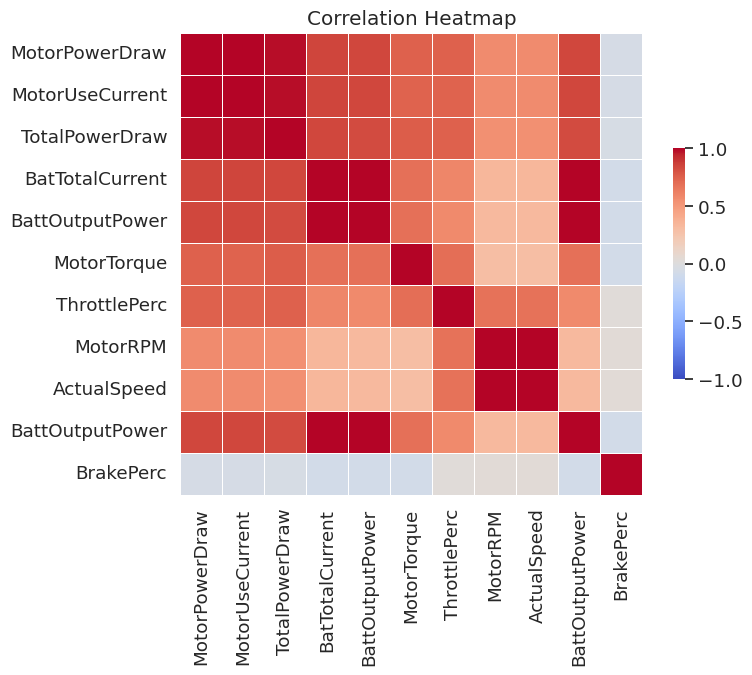

In [19]:
#make a new heatmap based onm the limited df 'limited_col_df'
floats = limited_col_df.select_dtypes(include="float64")
correlation_matrix= floats.corr()

# Set up the heatmap figure size
plt.figure(figsize=(8, 6))

# Customize the heatmap using seaborn's heatmap function without annotations
heatmap = sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5},
)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Set font scale for better readability
sns.set(font_scale=1.2)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

The features of the limited_col_df DF  with high r values are 'MotorPowerDraw', 'MotorUseCurrent', 'TotalPowerDraw', 'BatTotalCurrent' , 'BattOutputPower' , 'MotorTorque' ,'ThrottlePerc' , 'MotorRPM' ,'ActualSpeed', 'BattOutputPower', 'BrakePerc''

Correlation values with 'TargetColumn':
MotorUseCurrent    0.998843
TotalPowerDraw     0.978983
BatTotalCurrent    0.848416
BattOutputPower    0.838958
MotorTorque        0.749683
ThrottlePerc       0.742218
MotorRPM           0.562985
ActualSpeed        0.562985
BattOutputPower    0.838958
BrakePerc         -0.057981
Name: MotorPowerDraw, dtype: float64


/tmp/ipykernel_2300/2925791039.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')


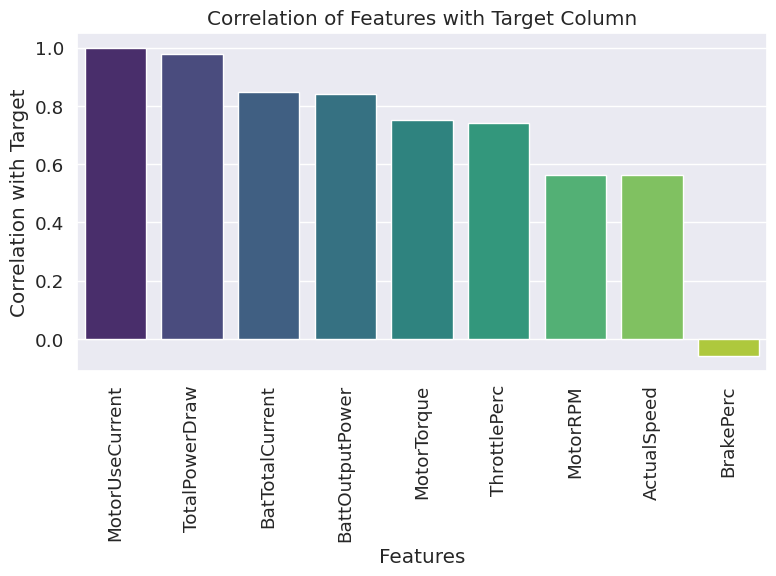

In [20]:

# Calculate correlation values ('r') against the target column
correlations = limited_col_df.corr()['MotorPowerDraw'].drop('MotorPowerDraw')  # Drop the correlation with itself

print("Correlation values with 'TargetColumn':")
print(correlations)
# Create a bar plot for correlation values
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Correlation of Features with Target Column')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

Summary of  MotorPowerDraw part 1
Dataset used: limited_col_df
Conclusion: The main features affecing the MotorPowerDraw are MotorUseCurrent', 'TotalPowerDraw', 'BatTotalCurrent' , 'BattOutputPower' , 'MotorTorque' ,'ThrottlePerc' , 'MotorRPM' ,'ActualSpeed', the feature 'BrakePerc' is negatively correlated woth 'MotorPowerDraw'.



In [21]:
limited_col_df.shape

(871721, 11)

MotorPowerDraw part 2

MULTIPLE LINEAR REGRESSION, try to make a model that fits the data with multiple coefficients

Via a pairplot (all variables plotted against eachother one-by-one)-check if there are correlations between them. 

We will do the following,
1.a Pair of the limited_col_df
1.b Pair plot of the comkplete de

Variables that are highly correlated can be reduced, keep one
BatTotalCurrent and MotorUseCurrent, keep BatTotalCurrent
BatTotalCurrent and BatOutputPower, keep BatTotalCurrent
Remove BatOutputPower and MotorUseCurrent
TotalPowerDraw is a feature based omn MotorPowerDraw, since we are looking for MotorPowerDraw, drop TotalPowerDraw


In [22]:
#create a new df with less coloms based on the the pairplot analysis above Summary of  MotorPowerDraw part 1. Drop higly correlated features ()
selected_columns = ['MotorPowerDraw', 'BatTotalCurrent'  , 'MotorTorque' ,'ThrottlePerc' , 'MotorRPM' ,'ActualSpeed', 'BrakePerc']
limited_col_df1 = df[selected_columns].copy()

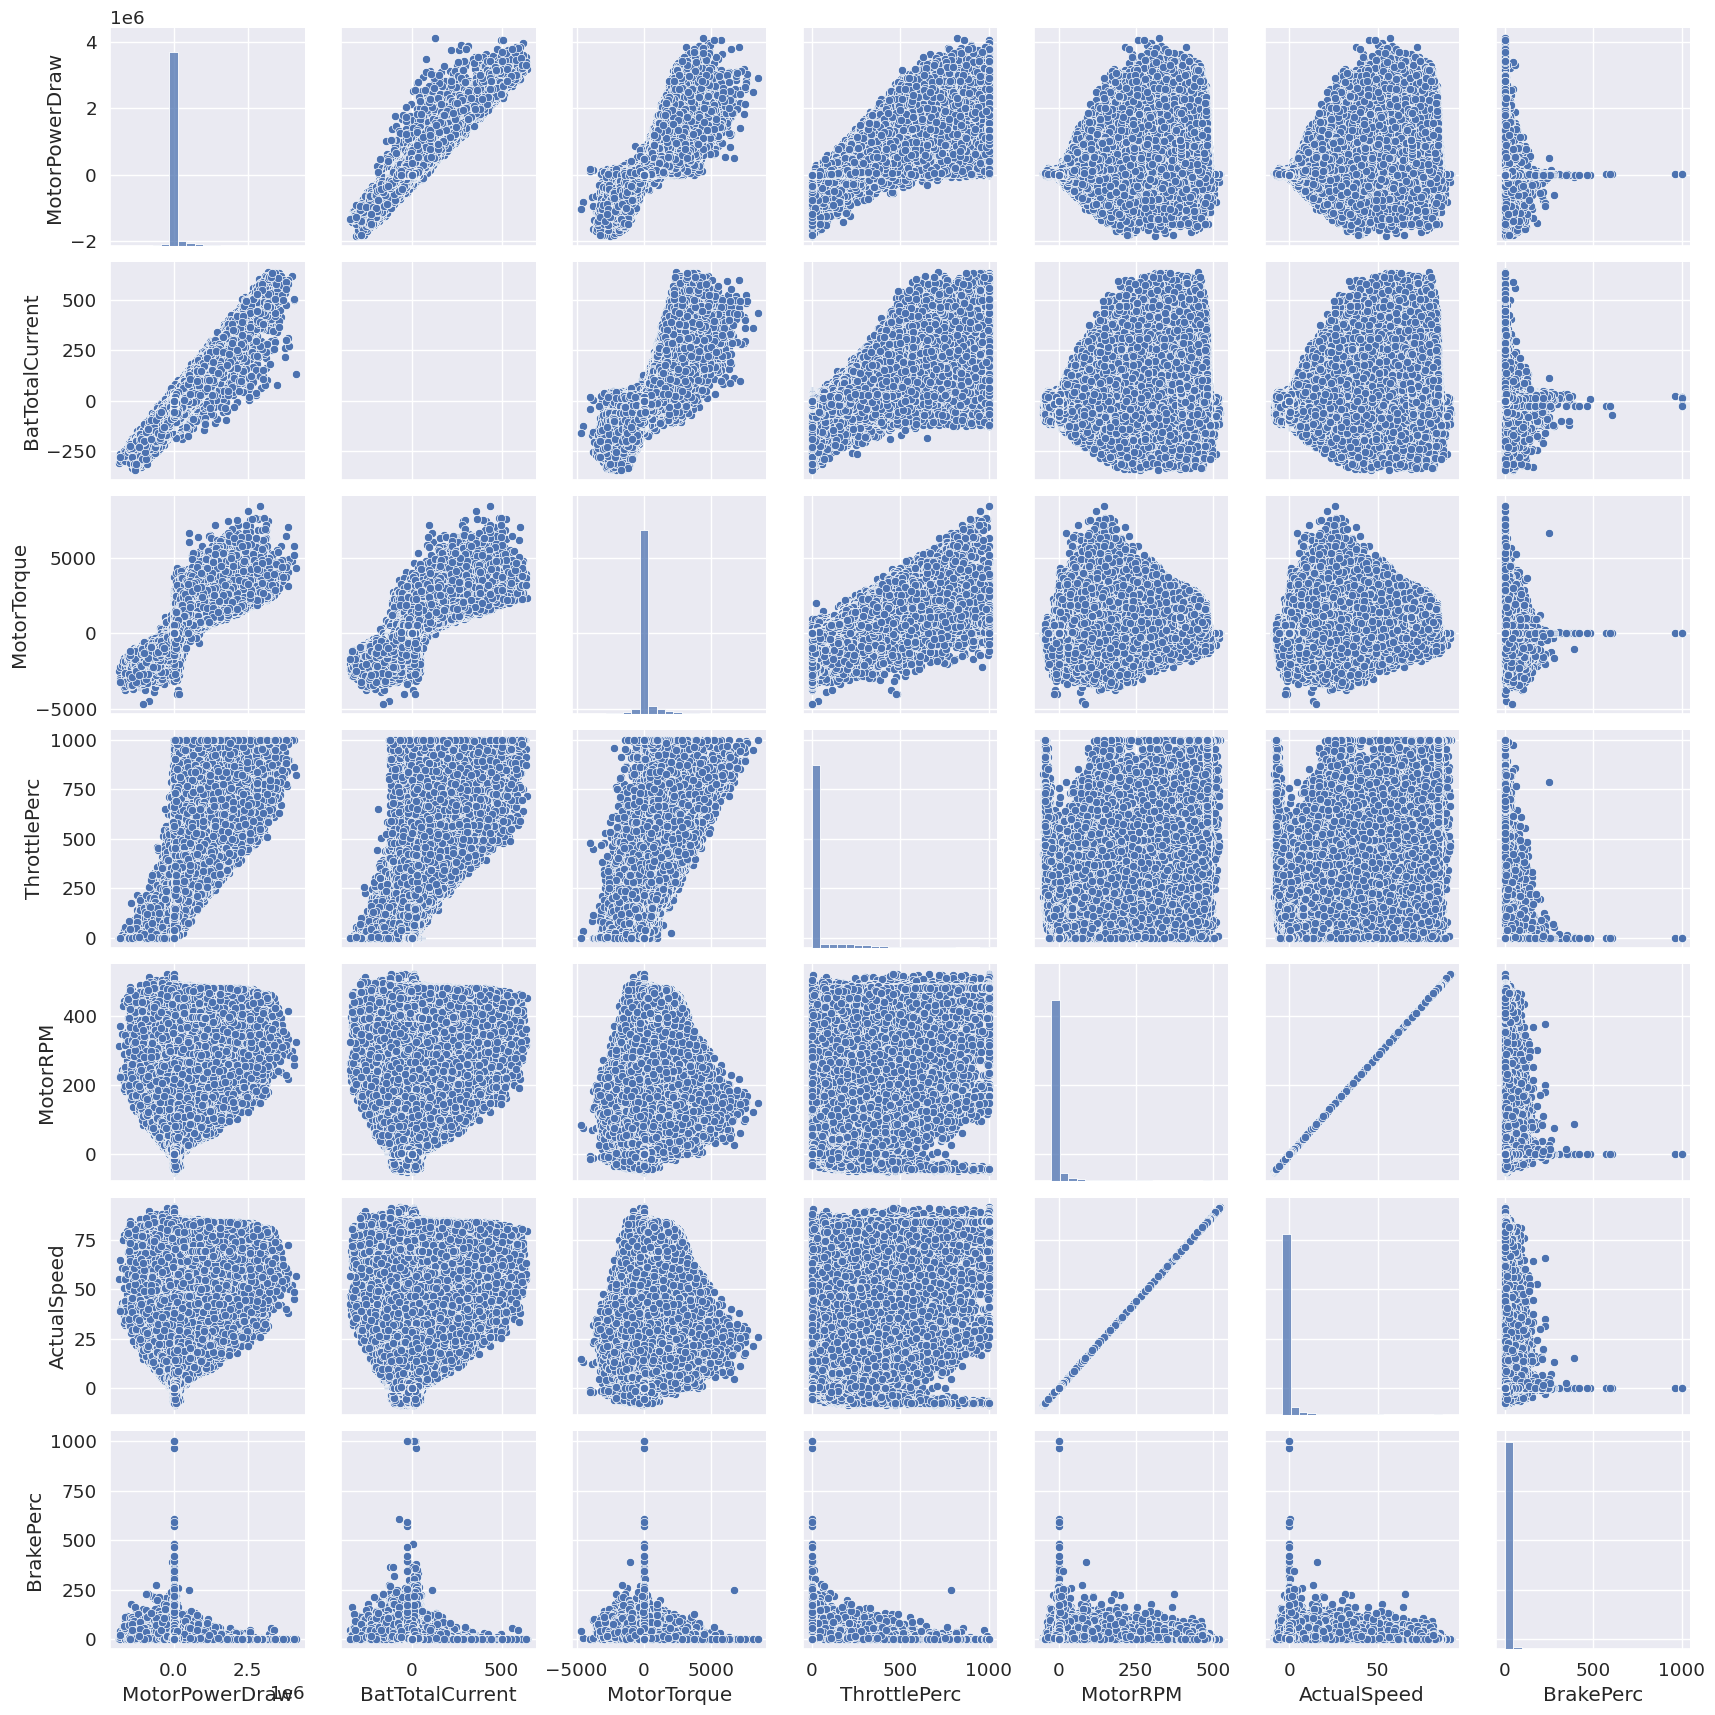

In [23]:
#run pairplot agian
sns.pairplot(limited_col_df1)
plt.show()

Build a linear model
$y = w_0 + w_1 x_1 + w_2 *x_2$

or 

MotorPowerDraw Y_Intercept =  + slope_2 x BatTotalCurrent + slope_3 x MotorTorque + slope_4 x ThrottlePerc + slope_5 x MotorRPM + slope_6 x ActualSpeed


as before, we prepare the designmatrix (adding a dummy variable $x_0 =1$ ) but now with the additional 'tail' variable. 

In [24]:
import statsmodels.api as sm
from patsy import dmatrices

In [25]:
#create a dataframe based onon the  original df with all rows still included and select the coloms from Summary of  MotorPowerDraw part 1 

y, X_multiple = dmatrices('MotorPowerDraw ~ + BatTotalCurrent + MotorTorque + ThrottlePerc + MotorRPM + ActualSpeed + BattOutputPower + MotorUseCurrent +TotalPowerDraw + BrakePerc', data=limited_col_df, return_type='dataframe')
X_multiple

Intercept  BatTotalCurrent  MotorTorque  ThrottlePerc  MotorRPM  \
0             1.0              0.0          0.0           0.0       0.0   
1             1.0              0.0          0.0           0.0       0.0   
2             1.0              0.0          0.0           0.0       0.0   
3             1.0              0.0          0.0           0.0       0.0   
4             1.0              0.0          0.0           0.0       0.0   
...           ...              ...          ...           ...       ...   
871716        1.0              0.0          0.0           0.0       0.0   
871717        1.0              0.0          0.0           0.0       0.0   
871718        1.0              0.0          0.0           0.0       0.0   
871719        1.0              0.0          0.0           0.0       0.0   
871720        1.0              0.0          0.0           0.0       0.0   

        ActualSpeed  BattOutputPower[0]  BattOutputPower[1]  MotorUseCurrent  \
0               0.0                 0.0                 0.0              0.0   
1               0.0                 0.0                 0.0              0.0   
2               0.0                 0.0                 0.0              0.0   
3               0.0                 0.0                 0.0              0.0   
4               0.0                 0.0                 0.0              0.0   
...             ...                 ...                 ...              ...   
871716          0.0                 0.0                 0.0              0.0   
871717          0.0                 0.0                 0.0              0.0   
871718          0.0                 0.0                 0.0              0.0   
871719          0.0                 0.0                 0.0              0.0   
871720          0.0                 0.0                 0.0              0.0   

        TotalPowerDraw  BrakePerc  
0                  0.0        0.0  
1                  0.0        0.0  
2                  0.0        0.0  
3                  0.0        0.0  
4                  0.0        0.0  
...                ...        ...  
871716             0.0        0.0  
871717             0.0        0.0  
871718             0.0        0.0  
871719             0.0        0.0  
871720             0.0        0.0  

[871577 rows x 11 columns]

higly correlated pairs make a line pattern. Higly correlated  variables 

Complexities with Multiple linear regression


* **Collinearity:** When the predictor variables are (almost) linear dependent. This may lead to extremely large and sensitive coefficients. A possible solution is to drop redundant input variables. The coefficients are wau to high

* **Confounders:** are important predictor variables that , when omitted, can lead to spurious relations in your model. 

End conclusion for MotorPowerDraw

Values are higy correlated, main features influencing MotorPowerDraw based on above analysis :|
BatTotalCurrent + MotorTorque + ThrottlePerc + MotorRPM + ActualSpeed'


PART 2: CompPower via dimensional reduction, goal is to find features most contributing to CompPower and visualize these

Singular Value Decomposition SVD

1. Data compression , keeping the largest singular values (and vecores) 
2 Noise reduction, smaller components are disregarded
3. latent semantci analysis: Understanding of relationships in texts
4. Image processing: 
5. Numerical algoritms: 
6> PCA 

DIMENSIONAL REDUCTION

Reduce random variables by optiaining the principal variables. We have a 45+ features dataset and needs to reduce to simplify the dataset wwhile retaing the meaningful information and to achive the following
1. Vizualize , try to get down to 2d or 3d
2. Computational efficiency: fewer dimension, faster computing
3. Curse of dimensionality: High dimensional spaces -requires high computer power and risk of overfitting (there will wlays be some points fitting a model , even if they are not actually determining the outcome)

Dimensional reduction
1. PCA : Identifies a set of new variables (PCs) that capture the most variances, the PCs are linear combination of original variables
2. t-distributed Stochastic Neighbour Embedding (t-SNE), used for vizualisation
3. 


Running PCA in order to reduce the number of coloms 

In [26]:
#Drop non-numerical coloms and standardize data, PCA does not work with nonm-numeric or NANs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#drop the non numerical coloms
# Dropping non-numeric columns before PCA
non_numeric_columns = limited_col_df1.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
limited_col_df1_numeric_scaled = limited_col_df1.drop(non_numeric_columns, axis=1)
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(limited_col_df1_numeric_scaled)

In [27]:
#PCA does not support NANs, replace the NAN values with 'mean' 

from sklearn.impute import SimpleImputer

# Assuming 'X' is your dataset
# Create an imputer to fill NaN values with the mean
imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = imputer.fit_transform(limited_col_df1_numeric_scaled)

In [28]:
print("Original shape:", df_numeric_imputed.shape)

Original shape: (871721, 7)


In [29]:
# Initialize PCA
pca = PCA(n_components=2)  # You can set the number of components to reduce to

# Fit PCA to the scaled data
pca.fit(df_numeric_imputed)

# Transform the data onto the new lower-dimensional space
df_pca = pd.DataFrame(pca.transform(df_numeric_imputed), columns=[f'PC_{i+1}' for i in range(2)])  # Creating DataFrame with PCA components

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

print("Original shape:", df_numeric_imputed.shape)
print("Transformed shape:", df_pca.shape)
print("Explained variance ratio:", explained_variance)

Original shape: (871721, 7)
Transformed shape: (871721, 2)
Explained variance ratio: [9.99997895e-01 1.94807249e-06]


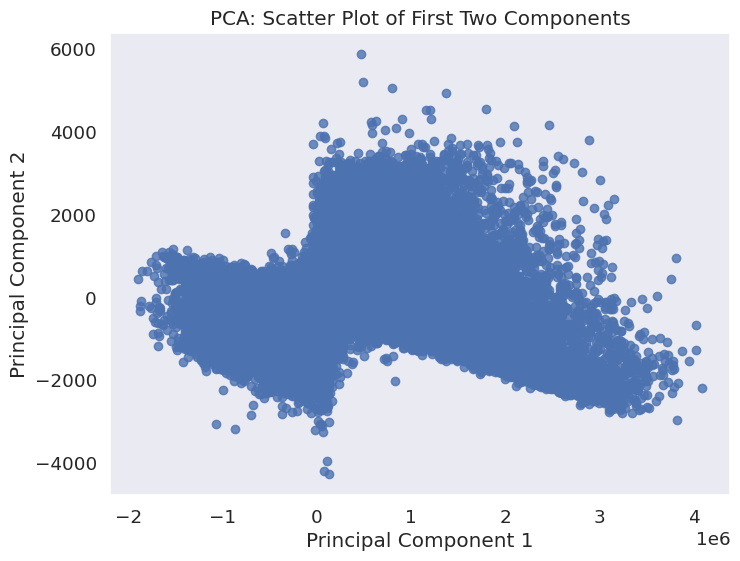

In [30]:
# Scatter plot using the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC_1'], df_pca['PC_2'], alpha=0.8)
plt.title('PCA: Scatter Plot of First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

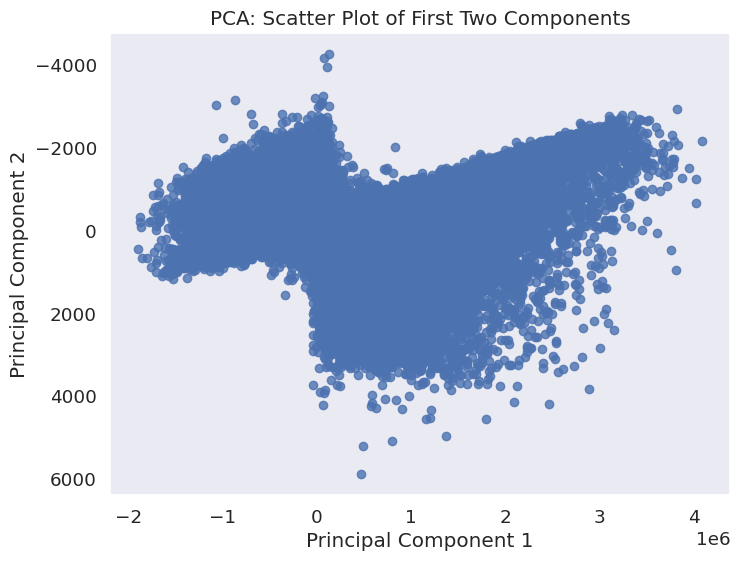

In [31]:


# Scatter plot using the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC_1'], df_pca['PC_2'], alpha=0.8)
plt.title('PCA: Scatter Plot of First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Flip the y-axis
plt.gca().invert_yaxis()

plt.grid()
plt.show()

What do these Graphs tells us? 
Conclusion: I Dont know

In [32]:
pca.explained_variance_ratio_

array([9.99997895e-01, 1.94807249e-06])

What does the Variance rate tell us?
Conclusion: 9.99997897e-01 close to 1, this PC explains  (alsomt) ALL variance in the data
1.94806518e-06 close to 0, this PC explains nothing

Conclusion: PCA and t_SNE doesnt work well with this many features and data, continue trying finding clusters 

Continue testing other methods to find correlation
1. Correlation analysis
2. Feature importance using ML Models
3. Univariate Feature selection




In [33]:
#1 Correlation analysis for MotorPowerDraw to find the features deciding the MotorPowerDraw
# Calculate correlations
correlation_matrix = df1.corr()
target_correlation = correlation_matrix['MotorPowerDraw'].abs()

# Select features with high correlation
relevant_features = target_correlation[target_correlation > 0.5].index.tolist()

# Display the outcome
print("Correlation with the target variable:")
print(target_correlation)

print("\nFeatures with correlation > 0.5 with the target variable:")
print(relevant_features)

Correlation with the target variable:
BatMaxV            0.219570
BatMinV            0.223155
BatSOC             0.207195
BatTotalCurrent    0.870712
BatTotalVoltage    0.221667
CompOnOff          0.269792
StopOnOff          0.321753
ThrottlePerc       0.883902
BrakePerc          0.444681
Signal             0.151033
TotalDistance      0.015760
FrontAxle          0.005782
RearAxle1          0.010236
RearAxle2          0.007591
CompPower          0.058280
FC2AirFlow         0.078741
FC2Cool            0.128171
FC2Current         0.070106
FC2Volt            0.166506
FC3AirFlow         0.077859
FC3Cool            0.125896
FC3Current         0.067977
FC3Volt            0.167966
FC1AirFlow         0.078680
FC1Cool            0.117656
FC1Current         0.069949
FC1Volt            0.167618
GPSAltitude        0.027614
GPSLatitude        0.114151
GPSLongitude       0.124021
H2Perc             0.034242
H2Press            0.034936
H2Temp             0.025569
H2Weight           0.034473
HVACDraw  

Conclusion, the Pearson correlation measures the linear relationship between two continuous variables. It ranges between -1, 
BatTotalCurrent    0.870759, 
ThrottlePerc       0.889879 and BrakePerc          0.436061 has pretty high pearson values. 

In [34]:
#2 Feature Importance using Machine Learning Models for MotorPowerDraw:
from sklearn.ensemble import RandomForestRegressor

X = df1.drop('MotorPowerDraw', axis=1)
y = df1['MotorPowerDraw']

model = RandomForestRegressor()
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
relevant_features = feature_importances[feature_importances > 0.1].index.tolist()  # Adjust threshold as needed

# Display the outcome
# Displaying the outcome
print("Feature importances (Descending order):")
print(feature_importances.sort_values(ascending=False))

print("\nRelevant features with importances > 0.1:")
print(relevant_features)



Feature importances (Descending order):
MotorUseCurrent    0.167105
MotorTorque        0.152053
TotalPowerDraw     0.149683
BattOutputPower    0.144343
BatTotalCurrent    0.131943
ThrottlePerc       0.129270
ActualSpeed        0.019278
BrakePerc          0.010077
MotorRPM           0.009606
FC1AirFlow         0.009384
FC2AirFlow         0.007353
FC3AirFlow         0.006615
StopOnOff          0.005611
TotalFCPower       0.005556
FC1Current         0.003837
RearAxle2          0.003685
FC2Current         0.003461
FC3Volt            0.003401
H2Weight           0.003354
FC2Volt            0.002949
TotalDistance      0.002712
FC2Cool            0.002625
Signal             0.002456
FC3Cool            0.002450
FC3Current         0.002394
FrontAxle          0.002256
H2Temp             0.002232
BatSOC             0.001986
GPSLongitude       0.001388
MotorTemp          0.001335
GPSAltitude        0.001286
CompPower          0.001241
RearAxle1          0.001188
GPSLatitude        0.001183
BatTotal

Conclusion: The feature importances generated by a Random Forest Regressor indicate the contribution of each feature (predictor variable) in making accurate predictions within the model. The sum of the features always adds up to 1
BatTotalCurrent    0.167168, 
ThrottlePerc 0.134818, 
BrakePerc   0.009557 and to less degree, 
StopOnOff   0.015950 
are the strongest features for MotorPowerDraw due to Random Forest Regressor

In [35]:
#3 Univariate Feature Selection for MotorPowerDraw:

from sklearn.feature_selection import SelectKBest, f_regression

X = df1.drop('MotorPowerDraw', axis=1)
y = df1['MotorPowerDraw']

selector = SelectKBest(score_func=f_regression, k=10)  # Adjust k as needed
X_new = selector.fit_transform(X, y)

relevant_features = X.columns[selector.get_support()]

# Displaying the outcome
print("Selected Features using SelectKBest:")
print(relevant_features)

# Creating a new DataFrame with relevant features
df_selected_features_MotorPowerDraw = df1[relevant_features.tolist()]  # Convert relevant_features to a list and select corresponding columns
# Displaying the new DataFrame
print("DataFrame with Selected Features MotorPowerDraw:")
print(df_selected_features_MotorPowerDraw.head())

Selected Features using SelectKBest:
Index(['BatTotalCurrent', 'StopOnOff', 'ThrottlePerc', 'BrakePerc', 'MotorRPM',
       'MotorTorque', 'MotorUseCurrent', 'BattOutputPower', 'ActualSpeed',
       'TotalPowerDraw'],
      dtype='object')
DataFrame with Selected Features MotorPowerDraw:
                 BatTotalCurrent  StopOnOff  ThrottlePerc  BrakePerc  \
BatMaxV                 0.002403   0.113480      0.101010   0.061896   
BatMinV                -0.001050   0.111115      0.097065   0.061426   
BatSOC                  0.012029  -0.057584     -0.013792  -0.001859   
BatTotalCurrent         1.000000   0.187466      0.586090  -0.078552   
BatTotalVoltage         0.000238   0.112293      0.098631   0.061634   

                 MotorRPM  MotorTorque  MotorUseCurrent  BattOutputPower  \
BatMaxV          0.083458     0.042847         0.045295         0.000751   
BatMinV          0.080423     0.039649         0.041513        -0.002570   
BatSOC          -0.037323    -0.002857        -0.0

Conclusion:  Univariate Feature Selection selects the K most relevant features based on their relationship with the target variable.The correlation coefficient ranges between -1 and 1.

The result is a new df df_selected_features_MotorPowerDraw with the 10 most important feature coloms. NOTE: THe analysis of MotorPowerDraw stops here, 


In [36]:
#1 Correlation analysis for CompPower. tagert_Correlation set to 0.1
# Calculate correlations
correlation_matrix = df1.corr()
target_correlation = correlation_matrix['CompPower'].abs()

# Select features with high correlation
relevant_features = target_correlation[target_correlation > 0.1].index.tolist()

# Display the outcome
print("Correlation with the target variable:")
print(target_correlation)

print("\nFeatures with correlation > 0.1 with the target variable:")
print(relevant_features)

Correlation with the target variable:
BatMaxV            0.165397
BatMinV            0.165670
BatSOC             0.196660
BatTotalCurrent    0.037925
BatTotalVoltage    0.165702
CompOnOff          0.513462
StopOnOff          0.156430
ThrottlePerc       0.067808
BrakePerc          0.102302
Signal             0.184265
TotalDistance      0.321682
FrontAxle          0.325817
RearAxle1          0.334728
RearAxle2          0.334131
CompPower          1.000000
FC2AirFlow         0.013625
FC2Cool            0.044387
FC2Current         0.040439
FC2Volt            0.103794
FC3AirFlow         0.013942
FC3Cool            0.046767
FC3Current         0.038966
FC3Volt            0.102798
FC1AirFlow         0.013810
FC1Cool            0.046813
FC1Current         0.039762
FC1Volt            0.103708
GPSAltitude        0.026217
GPSLatitude        0.237363
GPSLongitude       0.236108
H2Perc             0.317052
H2Press            0.315689
H2Temp             0.328181
H2Weight           0.317426
HVACDraw  

Conclusion, the Pearson correlation measures the linear relationship between two continuous variables. It ranges between -1, 
CompOnOff          0.507621 (obvious the highets value) 
BatSOC             0.2245011 
FrontAxle          0.323916
RearAxle1          0.333075
RearAxle2          0.332457 
BatTotalVoltage    0.201526 

The Weight (Front, RearAxle) seem to have a big impact on CompPower. A possibnle reason is that the compressor has to work harder to compress the waste when it is full

In [37]:
#2 Feature Importance using Machine Learning Models for CompPower:
from sklearn.ensemble import RandomForestRegressor

X = df1.drop('CompPower', axis=1)
y = df1['CompPower']

model = RandomForestRegressor()
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
relevant_features = feature_importances[feature_importances > 0.1].index.tolist()  # Adjust threshold as needed

# Display the outcome
# Displaying the outcome
print("Feature importances:")
print(feature_importances)

print("\nRelevant features with importances > 0.1:")
print(relevant_features)

Feature importances:
BatMaxV            0.007124
BatMinV            0.006927
BatSOC             0.009631
BatTotalCurrent    0.013566
BatTotalVoltage    0.003878
CompOnOff          0.122579
StopOnOff          0.293835
ThrottlePerc       0.015581
BrakePerc          0.006746
Signal             0.006904
TotalDistance      0.016921
FrontAxle          0.022956
RearAxle1          0.017384
RearAxle2          0.037785
FC2AirFlow         0.006243
FC2Cool            0.000896
FC2Current         0.000209
FC2Volt            0.004643
FC3AirFlow         0.000692
FC3Cool            0.002177
FC3Current         0.002247
FC3Volt            0.005984
FC1AirFlow         0.001275
FC1Cool            0.002837
FC1Current         0.000725
FC1Volt            0.001300
GPSAltitude        0.002293
GPSLatitude        0.025213
GPSLongitude       0.011266
H2Perc             0.026124
H2Press            0.041481
H2Temp             0.031941
H2Weight           0.011514
HVACDraw           0.013775
MotorRPM           0.055141

Conclusion: The feature importances generated by a Random Forest Regressor indicate the contribution of each feature (predictor variable) in making accurate predictions within the model. The sum of the features always adds up to 1


FrontAxle          0.022278
RearAxle1          0.033701
RearAxle2          0.029782
CompOnOff          0.130936
StopOnOff          0.264092
ThrottlePerc       0.013402

Again , the weight (Axles) are strong, the StopOnOff (emergency button) , throttelperc and CompOnOf are less strong

In [38]:
#3 Univariate Feature Selection for CompPower:

from sklearn.feature_selection import SelectKBest, f_regression

X = df1.drop('CompPower', axis=1)
y = df1['CompPower']

selector = SelectKBest(score_func=f_regression, k=10)  # Adjust k as needed
X_new = selector.fit_transform(X, y)

relevant_features = X.columns[selector.get_support()]

# Displaying the outcome CompPower
print("Selected Features using SelectKBest:")
print(relevant_features)
# Creating a new DataFrame with relevant features
df_selected_features_CompPower = df1[relevant_features.tolist()]  # Convert relevant_features to a list and select corresponding columns

# Displaying the new DataFrame
print("DataFrame with Selected Features CompPower:")
print(df_selected_features_CompPower.head())


Selected Features using SelectKBest:
Index(['CompOnOff', 'TotalDistance', 'FrontAxle', 'RearAxle1', 'RearAxle2',
       'GPSLatitude', 'H2Perc', 'H2Press', 'H2Temp', 'H2Weight'],
      dtype='object')
DataFrame with Selected Features CompPower:
                 CompOnOff  TotalDistance  FrontAxle  RearAxle1  RearAxle2  \
BatMaxV           0.171922       0.199503   0.105687   0.107655   0.107459   
BatMinV           0.171211       0.197143   0.103426   0.105371   0.105178   
BatSOC            0.071833      -0.006185  -0.079492  -0.075794  -0.076836   
BatTotalCurrent   0.068561       0.193734   0.188329   0.203444   0.201834   
BatTotalVoltage   0.171180       0.198006   0.104227   0.106176   0.105982   

                 GPSLatitude    H2Perc   H2Press    H2Temp  H2Weight  
BatMaxV            -0.059220  0.094860  0.090950  0.066502  0.094625  
BatMinV            -0.059531  0.092881  0.089030  0.065008  0.092654  
BatSOC             -0.064253 -0.079872 -0.077887 -0.047433 -0.079078  
Ba

Conclusion:  Univariate Feature Selection selects the K most relevant features based on their relationship with the target variable.The correlation coefficient ranges between -1 and 1.

The result is a new df df_selected_features_CompPower with the 10 most important feature coloms.  


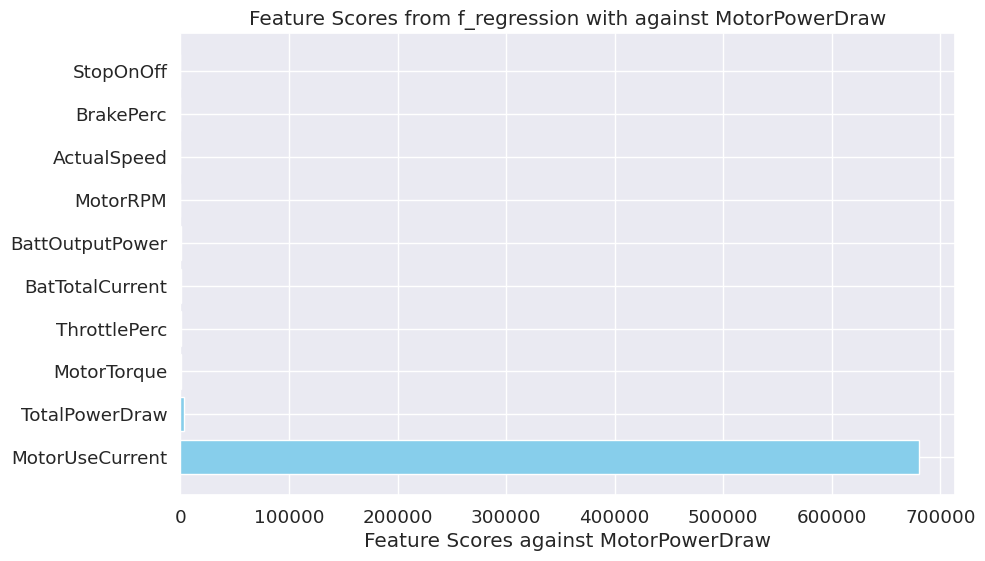

In [39]:
# Continue based on the variables found with #3 univariate Feature Selection for CompPower
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression

# Assuming 'df1' is your DataFrame with the necessary data

# Feature selection
X = df1.drop('MotorPowerDraw', axis=1)
y = df1['MotorPowerDraw']

selector = SelectKBest(score_func=f_regression, k=10)  # Adjust k as needed
X_new = selector.fit_transform(X, y)

relevant_features = X.columns[selector.get_support()]

# Get feature scores
scores = selector.scores_

# Create a DataFrame with relevant features and their scores
feature_scores = pd.DataFrame({'Features': X.columns, 'Scores': scores})
selected_features = feature_scores[feature_scores['Features'].isin(relevant_features)]

# Sort the selected features by their scores
selected_features = selected_features.sort_values(by='Scores', ascending=False)

# Plotting the scores of the selected features
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Features'], selected_features['Scores'], color='skyblue')
plt.xlabel('Feature Scores against MotorPowerDraw')
plt.title('Feature Scores from f_regression with against MotorPowerDraw')
plt.show()

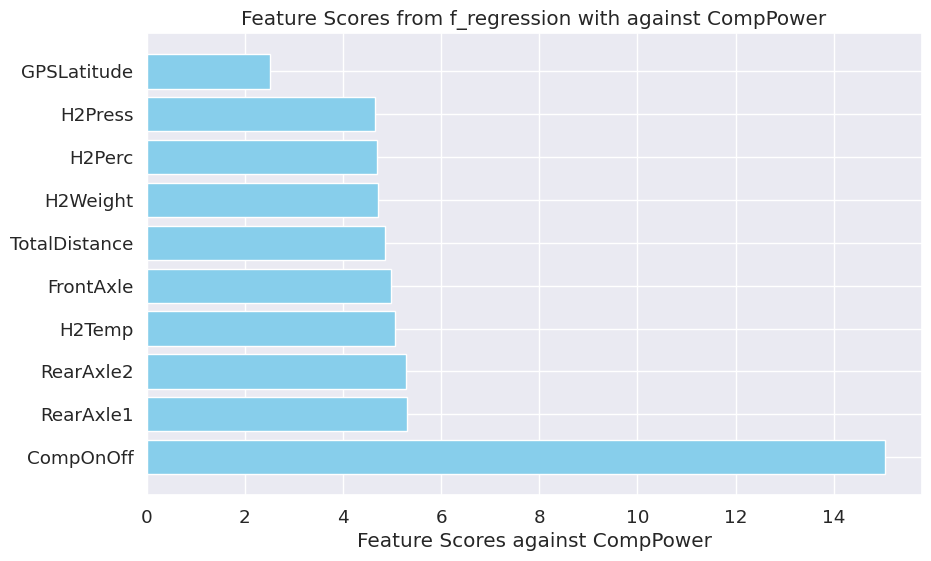

In [40]:
# Continue based on the variables found with #3 univariate Feature Selection for CompPower
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression

# Assuming 'df1' is your DataFrame with the necessary data

# Feature selection
X = df1.drop('CompPower', axis=1)
y = df1['CompPower']

selector = SelectKBest(score_func=f_regression, k=10)  # Adjust k as needed
X_new = selector.fit_transform(X, y)

relevant_features = X.columns[selector.get_support()]

# Get feature scores
scores = selector.scores_

# Create a DataFrame with relevant features and their scores
feature_scores = pd.DataFrame({'Features': X.columns, 'Scores': scores})
selected_features = feature_scores[feature_scores['Features'].isin(relevant_features)]

# Sort the selected features by their scores
selected_features = selected_features.sort_values(by='Scores', ascending=False)

# Plotting the scores of the selected features
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Features'], selected_features['Scores'], color='skyblue')
plt.xlabel('Feature Scores against CompPower')
plt.title('Feature Scores from f_regression with against CompPower')
plt.show()

In [41]:
#make a smaller dataset, drop correlated coloms (Rearaxle2 and Front Axle) and obvious coloms (CompOnOff)
#Remove rows where CompOnOff=0 (off)
df_univariate_CompPower = df[df['CompOnOff'] != 0]
selected_columns = ['BatSOC', 'MotorTemp'  , 'H2Press' ,'H2Perc' , 'H2Weight' , 'H2Temp', 'RearAxle2']
df_univariate_CompPower = df_univariate_CompPower[selected_columns].copy()


In [42]:
df_univariate_CompPower

BatSOC  MotorTemp     H2Press  H2Perc  H2Weight  H2Temp  RearAxle2
62      97.000  37.000000  255.850000  41.800  6646.575    23.0     4800.0
63      97.000  37.000000  255.800000  41.725  6643.750    23.0     4840.0
64      97.000  37.000000  255.850000  41.700  6643.300    23.0     4800.0
65      96.325  37.000000  255.650000  41.550  6640.875    23.0     4800.0
66      96.000  37.000000  255.800000  41.700  6646.575    23.0     4800.0
...        ...        ...         ...     ...       ...     ...        ...
864340  75.000  27.100000  275.050000  46.000  7321.325     7.0     4800.0
864341  75.000  27.075000  275.100000  46.000  7318.075     7.0     4800.0
864342  75.000  27.095238  275.100000  46.000  7315.975     7.0     4800.0
864343  75.000  27.075472  275.025000  46.000  7316.725     7.0     4800.0
864344  45.000  27.088235  274.933333  46.000  7313.700     7.0     4800.0

[144981 rows x 7 columns]

In [43]:
#Drop non-numerical coloms and standardize data for df_univariate_CompPower
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#drop the non numerical coloms
# Dropping non-numeric columns before PCA
non_numeric_columns = df_univariate_CompPower.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
df_univariate_CompPower_numeric_scaled = df_univariate_CompPower.drop(non_numeric_columns, axis=1)
# Standardize the data
scaler = StandardScaler()
scaled_data_CompPower_numeric = scaler.fit_transform(df_univariate_CompPower_numeric_scaled)

In [44]:
#remove NANS
from sklearn.impute import SimpleImputer

# Assuming 'X' is your dataset
# Create an imputer to fill NaN values with the mean
imputer = SimpleImputer(strategy='mean')
scaled_data_CompPower_numeric_noNAN = imputer.fit_transform(df_univariate_CompPower_numeric_scaled)
#scaled_data_CompPower_numeric_noNAN is now an array, no df


# Convert the NumPy array back to a DataFrame

# Assuming limited_col_df1_numeric_scaled is your DataFrame
imputed_values = imputer.fit_transform(scaled_data_CompPower_numeric_noNAN)

# Convert the NumPy array back to a DataFrame
df_scaled_data_CompPower_numeric_noNAN = pd.DataFrame(imputed_values, columns=df_univariate_CompPower_numeric_scaled.columns)

#We now have a scaled df without no nans for the most important features for COmpPower: df_scaled_data_CompPower_numeric_noNAN


In [45]:
df_scaled_data_CompPower_numeric_noNAN.describe


<bound method NDFrame.describe of         BatSOC  MotorTemp     H2Press  H2Perc  H2Weight  H2Temp  RearAxle2
0       97.000  37.000000  255.850000  41.800  6646.575    23.0     4800.0
1       97.000  37.000000  255.800000  41.725  6643.750    23.0     4840.0
2       97.000  37.000000  255.850000  41.700  6643.300    23.0     4800.0
3       96.325  37.000000  255.650000  41.550  6640.875    23.0     4800.0
4       96.000  37.000000  255.800000  41.700  6646.575    23.0     4800.0
...        ...        ...         ...     ...       ...     ...        ...
144976  75.000  27.100000  275.050000  46.000  7321.325     7.0     4800.0
144977  75.000  27.075000  275.100000  46.000  7318.075     7.0     4800.0
144978  75.000  27.095238  275.100000  46.000  7315.975     7.0     4800.0
144979  75.000  27.075472  275.025000  46.000  7316.725     7.0     4800.0
144980  45.000  27.088235  274.933333  46.000  7313.700     7.0     4800.0

[144981 rows x 7 columns]>

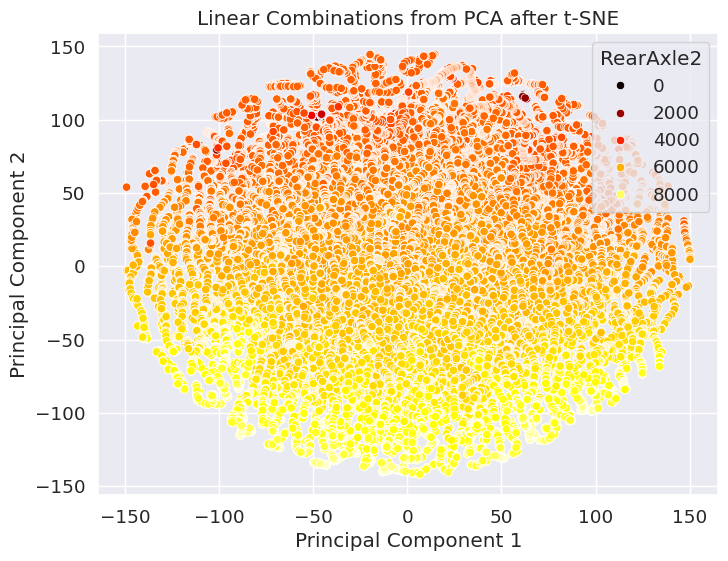

PC1 Recipe: [-0.99999535 -0.00306312]
PC2 Recipe: [-0.00306312  0.99999535]
Features contributing most to PC1: Index(['BatSOC', 'MotorTemp'], dtype='object')
Features contributing most to PC2: Index(['MotorTemp', 'BatSOC'], dtype='object')


In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df_scaled_data_CompPower_numeric_noNAN' is your DataFrame

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X2D_tsne = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)

# Apply PCA on the t-SNE transformed data
pca = PCA(n_components=2)
X2D_pca = pca.fit_transform(X2D_tsne)

# Plot the linear combinations from PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X2D_pca[:, 0], y=X2D_pca[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['RearAxle2'], palette=plt.cm.hot)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Linear Combinations from PCA after t-SNE')
plt.show()

# Access the PCA components (recipe for PCs)
pc_recipes = pca.components_

# PC1 recipe (coefficients for each original feature)
pc1_recipe = pc_recipes[0]

# PC2 recipe (coefficients for each original feature)
pc2_recipe = pc_recipes[1]

# Printing the recipes (coefficients)
print("PC1 Recipe:", pc1_recipe)
print("PC2 Recipe:", pc2_recipe)

# Get the column names (feature names) from the original DataFrame
feature_names = df_scaled_data_CompPower_numeric_noNAN.columns

# Access the PCA components (recipe for PCs)
pc_recipes = pca.components_

# Get the absolute coefficients for PC1 and PC2
pc1_recipe = abs(pc_recipes[0])
pc2_recipe = abs(pc_recipes[1])

# Identify the features contributing most to PC1 and PC2
features_pc1 = feature_names[pc1_recipe.argsort()[::-1]]
features_pc2 = feature_names[pc2_recipe.argsort()[::-1]]

# Printing the features contributing most to PC1 and PC2
print("Features contributing most to PC1:", features_pc1)
print("Features contributing most to PC2:", features_pc2)

<Axes: >

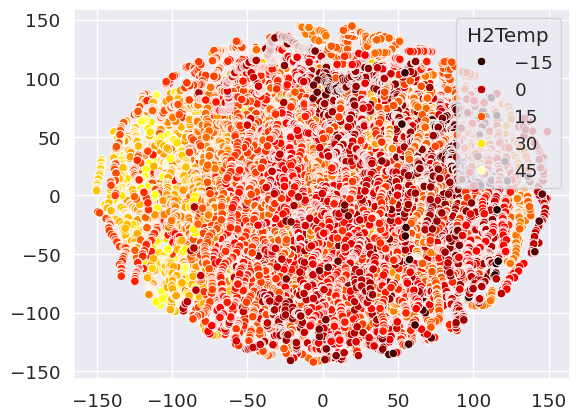

In [47]:
tsne = TSNE(n_components=2, random_state=42)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)
#sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['RearAxle2'], palette=plt.cm.hot)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['H2Temp'], palette=plt.cm.hot)
#sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['BatSOC'], palette=plt.cm.hot)

<Axes: >

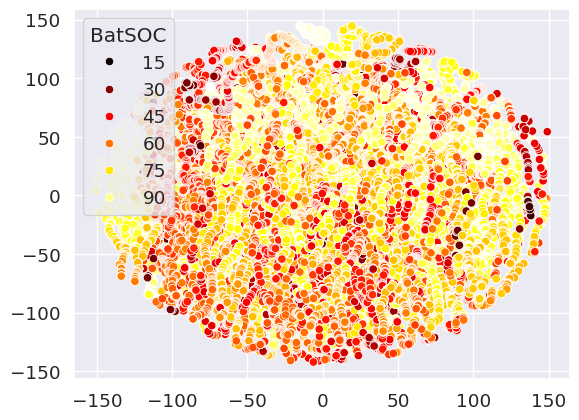

In [48]:
tsne = TSNE(n_components=2, random_state=42)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)
#sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['RearAxle2'], palette=plt.cm.hot)
#sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['H2Temp'], palette=plt.cm.hot)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['BatSOC'], palette=plt.cm.hot)

<Axes: >

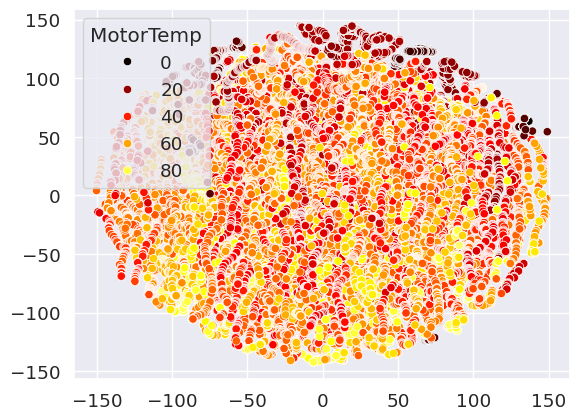

In [49]:
tsne = TSNE(n_components=2, random_state=42)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['MotorTemp'], palette=plt.cm.hot)

<Axes: >

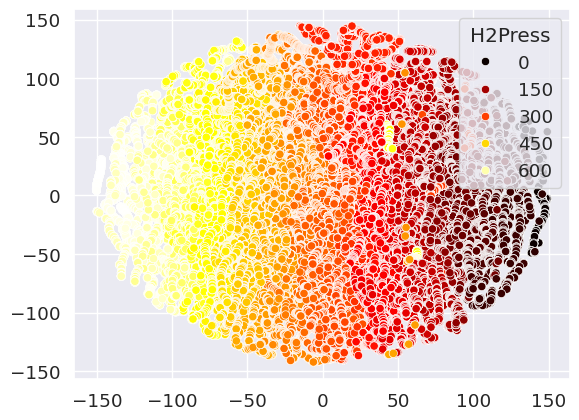

In [50]:
tsne = TSNE(n_components=2, random_state=42)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['H2Press'], palette=plt.cm.hot)

<Axes: >

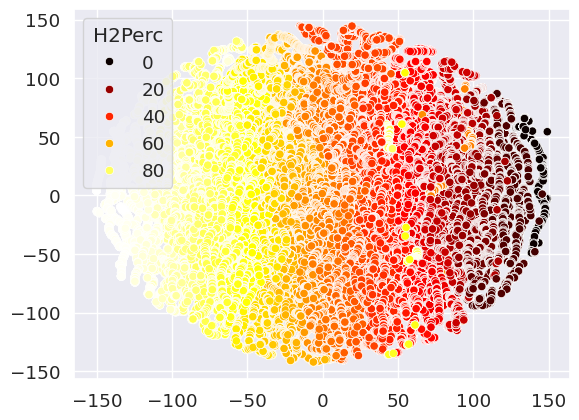

In [51]:
tsne = TSNE(n_components=2, random_state=42)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['H2Perc'], palette=plt.cm.hot)

<Axes: >

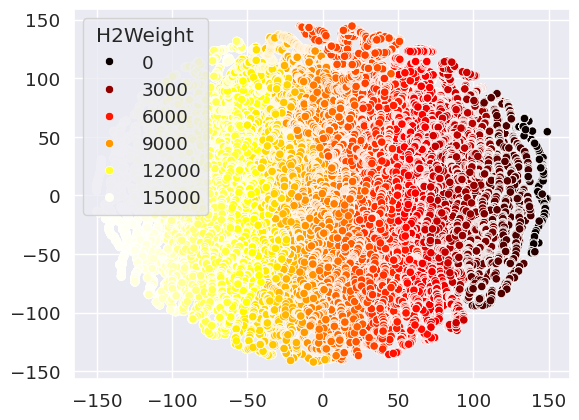

In [52]:
tsne = TSNE(n_components=2, random_state=42)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['H2Weight'], palette=plt.cm.hot)

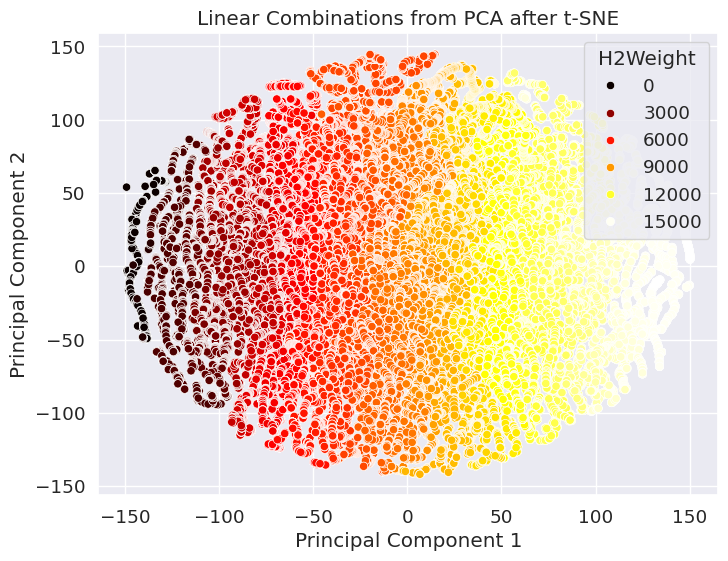

In [53]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df_scaled_data_CompPower_numeric_noNAN' is your DataFrame

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X2D_tsne = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)

# Apply PCA on the t-SNE transformed data
pca = PCA(n_components=2)
X2D_pca = pca.fit_transform(X2D_tsne)

# Plot the linear combinations from PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X2D_pca[:, 0], y=X2D_pca[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['H2Weight'], palette=plt.cm.hot)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Linear Combinations from PCA after t-SNE')
plt.show()


In [54]:
df_scaled_data_CompPower_numeric_noNAN

BatSOC  MotorTemp     H2Press  H2Perc  H2Weight  H2Temp  RearAxle2
0       97.000  37.000000  255.850000  41.800  6646.575    23.0     4800.0
1       97.000  37.000000  255.800000  41.725  6643.750    23.0     4840.0
2       97.000  37.000000  255.850000  41.700  6643.300    23.0     4800.0
3       96.325  37.000000  255.650000  41.550  6640.875    23.0     4800.0
4       96.000  37.000000  255.800000  41.700  6646.575    23.0     4800.0
...        ...        ...         ...     ...       ...     ...        ...
144976  75.000  27.100000  275.050000  46.000  7321.325     7.0     4800.0
144977  75.000  27.075000  275.100000  46.000  7318.075     7.0     4800.0
144978  75.000  27.095238  275.100000  46.000  7315.975     7.0     4800.0
144979  75.000  27.075472  275.025000  46.000  7316.725     7.0     4800.0
144980  45.000  27.088235  274.933333  46.000  7313.700     7.0     4800.0

[144981 rows x 7 columns]

<Axes: >

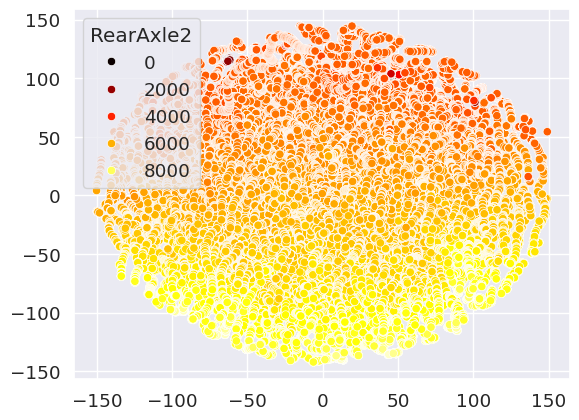

In [55]:
tsne = TSNE(n_components=2, random_state=42)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['RearAxle2'], palette=plt.cm.hot)

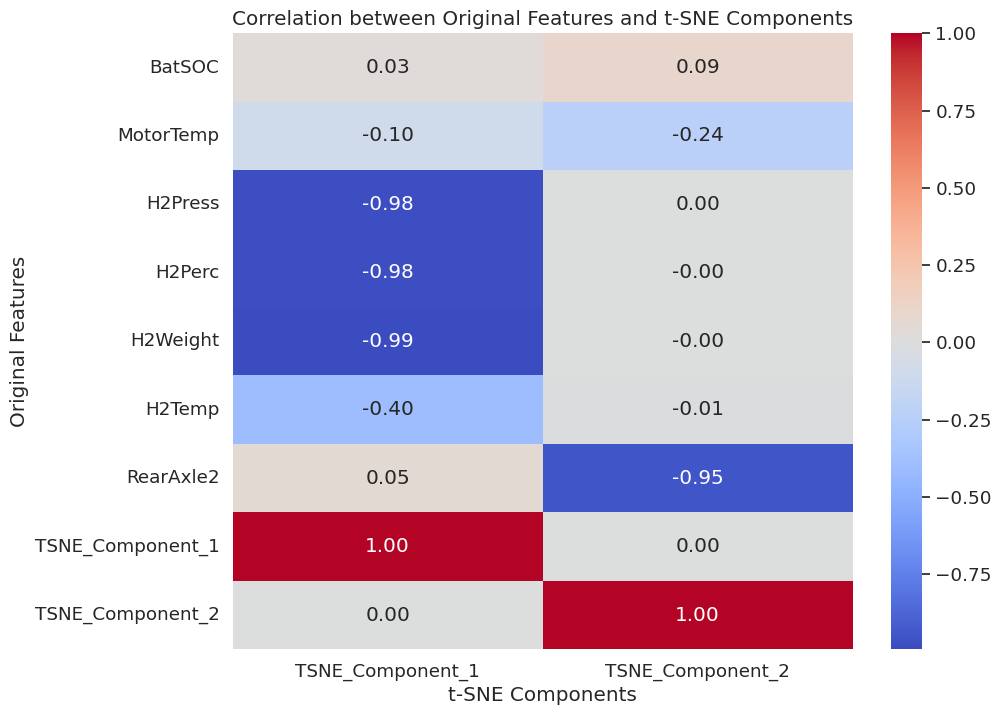

In [56]:
# Add t-SNE components to DataFrame df_scaled_data_CompPower_numeric_noNAN 
df_with_tsne = df_scaled_data_CompPower_numeric_noNAN.copy()
df_with_tsne['TSNE_Component_1'] = X2D[:, 0]
df_with_tsne['TSNE_Component_2'] = X2D[:, 1]

# Calculate correlations between original features and t-SNE components
correlation_matrix = df_with_tsne.corr()

# Extract correlations with t-SNE components
tsne_component_correlations = correlation_matrix[['TSNE_Component_1', 'TSNE_Component_2']]

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tsne_component_correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Original Features and t-SNE Components')
plt.xlabel('t-SNE Components')
plt.ylabel('Original Features')
plt.show()

Text(0.5, 0.92, 't-SNE Visualization (3D)')

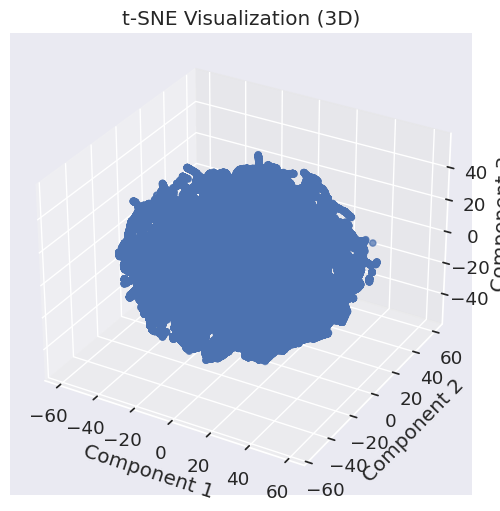

In [57]:
#Make the same t-SNE plot in 3d for CompPower
#from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X3D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the t-SNE output in 3D
ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], marker='o')

# Set labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('t-SNE Visualization (3D)')


In [58]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'df_scaled_data_CompPower_numeric_noNAN' is your DataFrame

# Perform t-SNE
tsne = TSNE(n_components=3, random_state=42)
X3D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)

# Create a color palette for the components
palette = sns.color_palette('husl', len(df_scaled_data_CompPower_numeric_noNAN['RearAxle2'].unique()))

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the t-SNE output in 3D with different colors for components
for component, color in zip(df_scaled_data_CompPower_numeric_noNAN['RearAxle2'].unique(), palette):
    indices = df_scaled_data_CompPower_numeric_noNAN['RearAxle2'] == component
    ax.scatter(X3D[indices, 0], X3D[indices, 1], X3D[indices, 2], marker='o', label=f'Component {component}', c=[color])

# Set labels and title
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('t-SNE Visualization (3D)')
ax.legend()

# Display the plot
plt.show()

ValueError: Image size of 500x128610 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

In [ ]:
#check the correlation between the original features and the t_SNE components for CompPower
# Add t-SNE components to DataFrame
df_with_tsne = df_scaled_data_CompPower_numeric_noNAN.copy()
df_with_tsne['TSNE_Component_1'] = X2D[:, 0]
df_with_tsne['TSNE_Component_2'] = X2D[:, 1]

# Calculate correlations between original features and t-SNE components
correlation_matrix = df_with_tsne.corr()

# Extract correlations with t-SNE components
tsne_component_correlations = correlation_matrix[['TSNE_Component_1', 'TSNE_Component_2']]

In [ ]:
#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt
#import seaborn as sns
from tqdm import tqdm

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=10, n_iter=500)
X2D = tsne.fit_transform(df_scaled_data_CompPower_numeric_noNAN)

# Plot the t-SNE reduced data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=df_scaled_data_CompPower_numeric_noNAN['RearAxle2'], palette=plt.cm.hot)
plt.title('t-SNE Projection')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()